# Inner model attemp


## 1. Files included: 
    # Immune
    "CD4+_T_Cells": "Immune",
    "CD8+_T_Cells": "Immune",
    "B_Cells": "Immune",
    "IRF7+_DCs": "Immune",
    "LAMP3+_DCs": "Immune",
    "Macrophages_1": "Immune",
    "Macrophages_2": "Immune",
    "Mast_Cells": "Immune",


    # Tumor
    "Prolif_Invasive_Tumor": "Tumor",
    "Invasive_Tumor": "Tumor",

    #early stage cancer
    "DCIS_1": "Early stage cancer",
    "DCIS_2": "Early stage cancer",

    # Connective tissue
    "Stromal": "Connective tissue",
    "Perivascular-Like": "Connective tissue",
    "Myoepi_ACTA2+": "Connective tissue",
    "Myoepi_KRT15+": "Connective tissue",

    #endothelial
    "Endothelial": "Endothelial",

## Files not included

    #hybrids
    "Stromal_and_T_Cell_Hybrid": "Hybrid",
    "T_Cell_and_Tumor_Hybrid": "Hybrid",

    # Unlabeled
    "Unlabeled": "Unlabeled"

### Tumor and early stage combined to make cancer file and others non-cancer

### Getting 2000 images total, so 1000 cancer and 1000 non-cancer. For cancer: 500 tumor and 500 early stage. For non-cancer: 333 connective, 333 endothelial and 334 immune

In [ ]:
# Cell 1: Imports
import pandas as pd
import os
import random
from sklearn.model_selection import train_test_split

# Set random seed for reproducibility
random.seed(42)

# Cell 2: Load Metadata
# Assuming your coordinate file is similar to this
cbr = pd.read_csv("metadata_code/cbr.csv")  # Contains 'index', 'axis-0', 'axis-1'
# Folder structure under 'final_data' like: Immune/, Tumor/, Early stage cancer/, Connective tissue/, Endothelial/
base_image_dir = "final_data"

# Cell 3: Mapping Folders to Categories
# Map folder names to a 'category' label
category_folder_map = {
    "Tumor": "Cancer",
    "Early stage cancer": "Cancer",
    "Connective tissue": "Non-Cancer",
    "Endothelial": "Non-Cancer",
    "Immune": "Non-Cancer"
}

# Cell 4: Build Full Metadata
all_images = []

for folder_name in os.listdir(base_image_dir):
    folder_path = os.path.join(base_image_dir, folder_name)
    if os.path.isdir(folder_path):
        for img_name in os.listdir(folder_path):
            if img_name.endswith(".png") or img_name.endswith(".jpg"):
                img_id = img_name.split('.')[0]  # Assuming filenames are like cell_123_100.png or similar
                all_images.append({
                    "folder": folder_name,
                    "file_name": img_name,
                    "path": os.path.join(folder_path, img_name),
                    "category_type": category_folder_map[folder_name],
                    "specific_category": folder_name
                })

df_images = pd.DataFrame(all_images)

# Merge coordinates
# Assuming 'index' from cbr is matching with the image ids in some way
# Here, fix if needed (may need to strip "cell_" etc from filename)

cbr['index'] = cbr['index'].astype(str)
df_images['img_index'] = df_images['file_name'].str.extract(r'(\d+)')
df = pd.merge(df_images, cbr, left_on='img_index', right_on='index')

print(f"Total images with coordinates: {len(df)}")

# Cell 5: Define Quadrants
x_mid = df["axis-1"].median()
y_mid = df["axis-0"].median()

def get_quadrant(row):
    if row["axis-1"] < x_mid and row["axis-0"] < y_mid:
        return "Q1"  # Top-left
    elif row["axis-1"] >= x_mid and row["axis-0"] < y_mid:
        return "Q2"  # Top-right
    elif row["axis-1"] < x_mid and row["axis-0"] >= y_mid:
        return "Q3"  # Bottom-left
    else:
        return "Q4"  # Bottom-right

df["quadrant"] = df.apply(get_quadrant, axis=1)

# Cell 6: Sampling the Correct Numbers
# Cancer: 500 Tumor + 500 Early Stage
tumor = df[df['specific_category'] == "Tumor"].sample(500, random_state=42)
early_stage = df[df['specific_category'] == "Early stage cancer"].sample(500, random_state=42)

# Non-Cancer: 333 Connective + 333 Endothelial + 334 Immune
connective = df[df['specific_category'] == "Connective tissue"].sample(333, random_state=42)
endothelial = df[df['specific_category'] == "Endothelial"].sample(333, random_state=42)
immune = df[df['specific_category'] == "Immune"].sample(334, random_state=42)

# Combine
final_df = pd.concat([tumor, early_stage, connective, endothelial, immune])
print(f"Total sampled images: {len(final_df)}")

# Cell 7: Quadrant Balancing
# Now ensure each quadrant has ~250 images proportionally

# Split per quadrant
quadrant_groups = final_df.groupby('quadrant')

balanced_samples = []
for quadrant, group in quadrant_groups:
    cancer_samples = group[group['category_type'] == "Cancer"]
    non_cancer_samples = group[group['category_type'] == "Non-Cancer"]

    n_total = 250  # target for each quadrant
    n_cancer = int(n_total * 0.5)  # ~50%
    n_non_cancer = n_total - n_cancer

    sampled_cancer = cancer_samples.sample(min(n_cancer, len(cancer_samples)), random_state=42)
    sampled_non_cancer = non_cancer_samples.sample(min(n_non_cancer, len(non_cancer_samples)), random_state=42)

    balanced_samples.append(pd.concat([sampled_cancer, sampled_non_cancer]))

final_balanced_df = pd.concat(balanced_samples)
print(f"Final images after quadrant balancing: {len(final_balanced_df)}")

# Cell 8: Final Outputs
# Save the mapping
final_balanced_df[['path', 'folder', 'file_name', 'category_type', 'specific_category', 'quadrant']].to_csv("quadrant_assignment.csv", index=False)

print("Saved 'quadrant_assignment.csv' successfully.")

# Optional: Display quadrant counts
print(final_balanced_df['quadrant'].value_counts())
print(final_balanced_df.groupby(['quadrant', 'category_type']).size())


In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the file that we created before
df = pd.read_csv("quadrant_assignment.csv")

# Split quadrants
train_val_df = df[df['quadrant'].isin(['Q1', 'Q2', 'Q3'])]  # Training + Validation quadrants
test_df = df[df['quadrant'] == 'Q4']                        # Testing quadrant

# Now split train_val_df into train and validation
train_df, val_df = train_test_split(train_val_df, test_size=0.2, random_state=42, stratify=train_val_df['category_type'])

# Check the sizes
print(f"Training images: {len(train_df)}")
print(f"Validation images: {len(val_df)}")
print(f"Testing images: {len(test_df)}")

# Save these splits if you want
train_df.to_csv("train_split.csv", index=False)
val_df.to_csv("val_split.csv", index=False)
test_df.to_csv("test_split.csv", index=False)

print("Saved 'train_split.csv', 'val_split.csv', 'test_split.csv' successfully.")


Training images: 600
Validation images: 150
Testing images: 250
Saved 'train_split.csv', 'val_split.csv', 'test_split.csv' successfully.


In [6]:


import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
import numpy as np


seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)


# --- Step 1: Load the CSVs ---
train_df = pd.read_csv("train_split.csv")
val_df = pd.read_csv("val_split.csv")
test_df = pd.read_csv("test_split.csv")

# --- Step 2: Image Data Generators ---
# Basic data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

# --- Step 3: Flow from dataframe ---
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='path',
    y_col='category_type',
    target_size=(224, 224),
    class_mode='binary',
    batch_size=32,
    shuffle=True
)

val_generator = val_test_datagen.flow_from_dataframe(
    val_df,
    x_col='path',
    y_col='category_type',
    target_size=(224, 224),
    class_mode='binary',
    batch_size=32,
    shuffle=False
)

test_generator = val_test_datagen.flow_from_dataframe(
    test_df,
    x_col='path',
    y_col='category_type',
    target_size=(224, 224),
    class_mode='binary',
    batch_size=32,
    shuffle=False
)

# --- Step 4: Build VGG19 Model ---
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base VGG19 layers
for layer in base_model.layers:
    layer.trainable = False

# Custom Head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)  # Binary output (Cancer vs Non-Cancer)

model = Model(inputs=base_model.input, outputs=predictions)

# --- Step 5: Compile ---
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# --- Step 6: Train ---
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[early_stop]
)

# --- Step 7: Evaluate on Test ---
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc*100:.2f}%")


/Users/tanvibangar/.virtualenvs/r-tensorflow/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Found 600 validated image filenames belonging to 2 classes.
Found 150 validated image filenames belonging to 2 classes.
Found 250 validated image filenames belonging to 2 classes.


Epoch 1/20
19/19 [==============================] - 365s 19s/step - loss: 0.7234 - accuracy: 0.5450 - val_loss: 0.6532 - val_accuracy: 0.5733
Epoch 2/20
19/19 [==============================] - 212s 11s/step - loss: 0.6797 - accuracy: 0.5733 - val_loss: 0.6125 - val_accuracy: 0.7533
Epoch 3/20
19/19 [==============================] - 207s 11s/step - loss: 0.6614 - accuracy: 0.6200 - val_loss: 0.5868 - val_accuracy: 0.7533
Epoch 4/20
19/19 [==============================] - 197s 10s/step - loss: 0.6135 - accuracy: 0.6967 - val_loss: 0.5642 - val_accuracy: 0.7667
Epoch 5/20
19/19 [==============================] - 197s 10s/step - loss: 0.6240 - accuracy: 0.6833 - val_loss: 0.5457 - val_accuracy: 0.7600
Epoch 6/20
19/19 [==============================] - 197s 10s/step - loss: 0.5912 - accuracy: 0.6933 - val_loss: 0.5318 - val_accuracy: 0.7800
Epoch 7/20
19/19 [==============================] - 199s 11s/step - loss: 0.5692 - accuracy: 0.7083 - val_loss: 0.5188 - val_accuracy: 0.7800
Epoch 

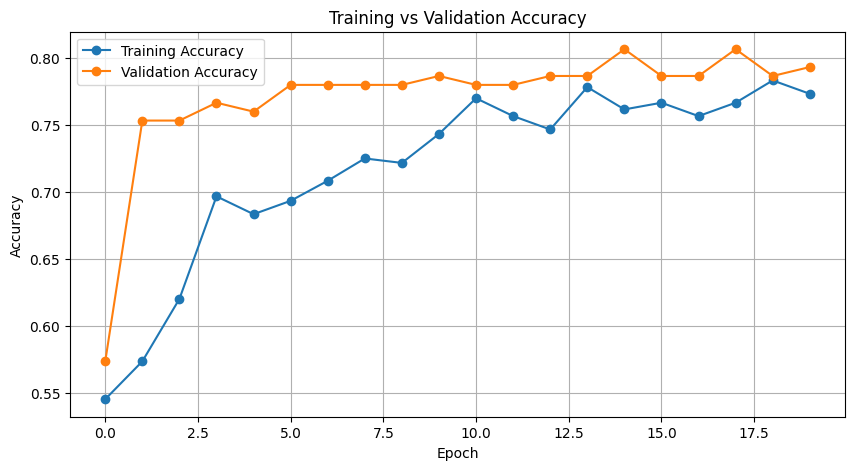

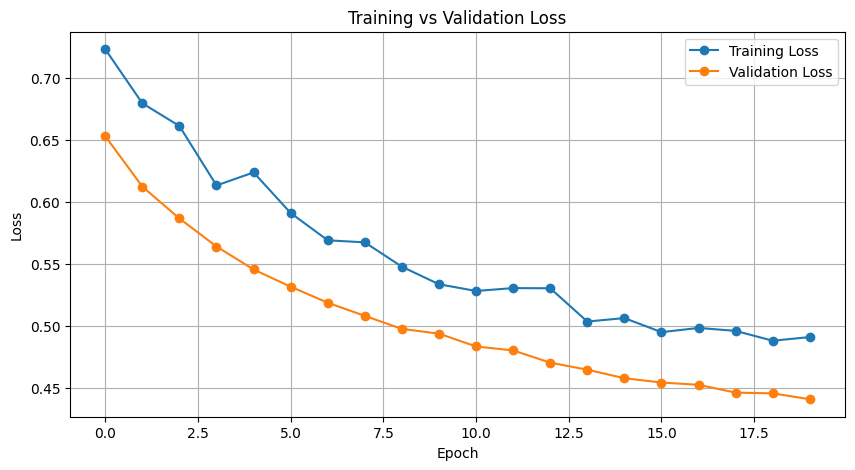

In [7]:
import matplotlib.pyplot as plt

# --- Step 1: Get History Data ---
# Assuming your training code was like:
# history = model.fit(train_generator, validation_data=validation_generator, epochs=EPOCHS, ...)

# --- Step 2: Plot Accuracy ---
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# --- Step 3: Plot Loss ---
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


8/8 [==============================] - 66s 8s/step


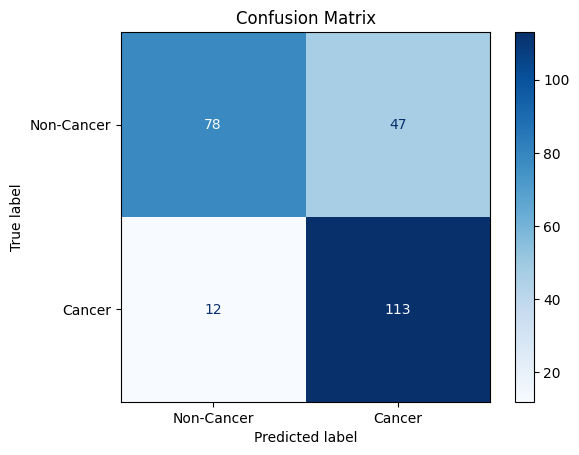

Classification Report:
              precision    recall  f1-score   support

  Non-Cancer       0.87      0.62      0.73       125
      Cancer       0.71      0.90      0.79       125

    accuracy                           0.76       250
   macro avg       0.79      0.76      0.76       250
weighted avg       0.79      0.76      0.76       250



In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# --- Step 1: Predict on test data ---
# Get model predictions
y_pred_probs = model.predict(test_generator)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()  # Threshold 0.5 for binary classification

# Get true labels
y_true = test_generator.classes  # Already ordered correctly since shuffle=False

# --- Step 2: Confusion Matrix ---
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Cancer", "Cancer"])

# --- Step 3: Plot Confusion Matrix ---
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# --- Step 4: Extra: Classification Report ---
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=["Non-Cancer", "Cancer"]))


## Data augmentation and fine tuning

In [ ]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping

# --- Step 1: Load the CSVs ---
train_df = pd.read_csv("train_split.csv")
val_df = pd.read_csv("val_split.csv")
test_df = pd.read_csv("test_split.csv")

# --- Step 2: Image Data Generators ---
# Boosted augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    zoom_range=0.3,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

# --- Step 3: Flow from dataframe ---
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='path',
    y_col='category_type',
    target_size=(224, 224),
    class_mode='binary',
    batch_size=32,
    shuffle=True
)

val_generator = val_test_datagen.flow_from_dataframe(
    val_df,
    x_col='path',
    y_col='category_type',
    target_size=(224, 224),
    class_mode='binary',
    batch_size=32,
    shuffle=False
)

test_generator = val_test_datagen.flow_from_dataframe(
    test_df,
    x_col='path',
    y_col='category_type',
    target_size=(224, 224),
    class_mode='binary',
    batch_size=32,
    shuffle=False
)

# --- Step 4: Build VGG19 Model ---
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze all layers first
for layer in base_model.layers:
    layer.trainable = False

# Custom Head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# --- Step 5: Compile (Initial Training) ---
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# --- Step 6: Train Top Layers ---
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[early_stop]
)

# --- Step 7: Fine-tuning ---
# Unfreeze last few layers of VGG19 for fine-tuning
for layer in base_model.layers[-8:]:  # Unfreeze last 8 layers
    layer.trainable = True

# Recompile with LOWER learning rate
model.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

# Fine-tune
fine_tune_history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[early_stop]
)

# --- Step 8: Evaluate on Test ---
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc*100:.2f}%")


In [ ]:
import matplotlib.pyplot as plt

# --- Step 1: Get History Data ---
# Assuming your training code was like:
# history = model.fit(train_generator, validation_data=validation_generator, epochs=EPOCHS, ...)

# --- Step 2: Plot Accuracy ---
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# --- Step 3: Plot Loss ---
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# --- Step 1: Predict on test data ---
# Get model predictions
y_pred_probs = model.predict(test_generator)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()  # Threshold 0.5 for binary classification

# Get true labels
y_true = test_generator.classes  # Already ordered correctly since shuffle=False

# --- Step 2: Confusion Matrix ---
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Cancer", "Cancer"])

# --- Step 3: Plot Confusion Matrix ---
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# --- Step 4: Extra: Classification Report ---
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=["Non-Cancer", "Cancer"]))

# Outer model

## Tried to manually calculate % from erics quadrant distribution images and it should be 35% cancer cells instead of 87% means big overlapping between cells (maybe)

In [10]:


import numpy as np
from PIL import Image
import tensorflow as tf
from tqdm import tqdm

# Load your trained CNN model
# model = tf.keras.models.load_model('your_model_path.h5')  # Update with your model path

# Define preprocessing transformations (resize, normalize, etc.)
def preprocess_tile(tile):
    tile = tile.resize((224, 224))  # Resize the tile to match model input size
    tile = np.array(tile) / 255.0  # Normalize the pixel values to [0, 1]
    tile = np.expand_dims(tile, axis=0)  # Add batch dimension for single prediction
    return tile

# Increase the limit for large images
Image.MAX_IMAGE_PIXELS = None  # Set to None to remove the limit

# Load big .tif image
big_image_path = 'bigimg.tif'  # Update this
big_img = Image.open(big_image_path)



# Get dimensions
width, height = big_img.size
print(f"Original size: {width}x{height}")

# Fourth quadrant = bottom-right
crop_box = (width // 2, height // 2, width, height)
fourth_quadrant = big_img.crop(crop_box)
cropped_width, cropped_height = fourth_quadrant.size
print(f"Cropped 4th quadrant size: {cropped_width}x{cropped_height}")

# Decide grid size
tile_size = 224  # Matching your model input size
stride = tile_size  # No overlap

# Calculate number of tiles
n_cols = cropped_width // stride
n_rows = cropped_height // stride
print(f"Tiles: {n_rows} rows x {n_cols} cols")

# Initialize counters
cancer_predictions = 0
total_tiles = 0

# Initialize list for batch processing
batch_tiles = []

# Initialize tqdm progress bar for batch processing
with tqdm(total=n_rows * n_cols, desc="Processing tiles", unit="tile") as pbar:
    # Loop over each tile and accumulate them into a batch
    for i in range(n_rows):
        for j in range(n_cols):
            # Define tile box
            left = j * stride
            upper = i * stride
            right = left + stride
            lower = upper + stride

            tile = fourth_quadrant.crop((left, upper, right, lower))

            # Preprocess tile
            tile_processed = preprocess_tile(tile)
            batch_tiles.append(tile_processed)

            # Process the batch when it reaches the batch size
            if len(batch_tiles) >= 32:  # Batch size = 32 (can be adjusted)
                # Convert list to numpy array (batch)
                batch_input = np.concatenate(batch_tiles, axis=0)  # Shape: (batch_size, 224, 224, 3)

                # Make batch predictions
                predictions = model.predict(batch_input, verbose=1, batch_size=32)

                # Update results
                for pred in predictions:
                    if pred > 0.5:  # Assuming binary classification with sigmoid activation
                        cancer_predictions += 1
                    total_tiles += 1

                # Clear the batch list for the next batch
                batch_tiles = []

            # Update progress bar for each tile processed
            pbar.update(1)

    # Handle remaining tiles if the batch is not full (less than 32 tiles)
    if batch_tiles:
        batch_input = np.concatenate(batch_tiles, axis=0)
        predictions = model.predict(batch_input, verbose=1, batch_size=32)
        for pred in predictions:
            if pred > 0.5:
                cancer_predictions += 1
            total_tiles += 1

# Final result
cancer_percentage = (cancer_predictions / total_tiles) * 100
print(f"\nPredicted cancerous tiles: {cancer_predictions}/{total_tiles}")
print(f"Cancer percentage: {cancer_percentage:.2f}%")


Original size: 30786x24241
Cropped 4th quadrant size: 15393x12121
Tiles: 54 rows x 68 cols


Processing tiles:   0%|          | 0/3672 [00:00<?, ?tile/s]

1/1 [==============================] - 8s 8s/step


Processing tiles:   1%|          | 32/3672 [00:08<16:56,  3.58tile/s]

1/1 [==============================] - 8s 8s/step


Processing tiles:   2%|▏         | 64/3672 [00:17<16:20,  3.68tile/s]

1/1 [==============================] - 8s 8s/step


Processing tiles:   3%|▎         | 96/3672 [00:26<16:03,  3.71tile/s]

1/1 [==============================] - 8s 8s/step


Processing tiles:   3%|▎         | 128/3672 [00:34<15:49,  3.73tile/s]

1/1 [==============================] - 8s 8s/step


Processing tiles:   4%|▍         | 160/3672 [00:42<15:35,  3.75tile/s]

1/1 [==============================] - 8s 8s/step


Processing tiles:   5%|▌         | 192/3672 [00:51<15:25,  3.76tile/s]

1/1 [==============================] - 9s 9s/step


Processing tiles:   6%|▌         | 224/3672 [01:00<15:24,  3.73tile/s]

1/1 [==============================] - 9s 9s/step


Processing tiles:   7%|▋         | 256/3672 [01:09<15:27,  3.68tile/s]

1/1 [==============================] - 9s 9s/step


Processing tiles:   8%|▊         | 288/3672 [01:17<15:19,  3.68tile/s]

1/1 [==============================] - 9s 9s/step


Processing tiles:   9%|▊         | 320/3672 [01:26<15:14,  3.67tile/s]

1/1 [==============================] - 9s 9s/step


Processing tiles:  10%|▉         | 352/3672 [01:35<15:10,  3.64tile/s]

1/1 [==============================] - 9s 9s/step


Processing tiles:  10%|█         | 384/3672 [01:44<15:04,  3.64tile/s]

1/1 [==============================] - 9s 9s/step


Processing tiles:  11%|█▏        | 416/3672 [01:53<14:55,  3.63tile/s]

1/1 [==============================] - 9s 9s/step


Processing tiles:  12%|█▏        | 448/3672 [02:02<14:50,  3.62tile/s]

1/1 [==============================] - 9s 9s/step


Processing tiles:  13%|█▎        | 480/3672 [02:11<14:45,  3.60tile/s]

1/1 [==============================] - 9s 9s/step


Processing tiles:  14%|█▍        | 512/3672 [02:19<14:33,  3.62tile/s]

1/1 [==============================] - 8s 8s/step


Processing tiles:  15%|█▍        | 544/3672 [02:28<14:17,  3.65tile/s]

1/1 [==============================] - 8s 8s/step


Processing tiles:  16%|█▌        | 576/3672 [02:36<14:02,  3.67tile/s]

1/1 [==============================] - 8s 8s/step


Processing tiles:  17%|█▋        | 608/3672 [02:45<13:50,  3.69tile/s]

1/1 [==============================] - 9s 9s/step


Processing tiles:  17%|█▋        | 640/3672 [02:54<13:57,  3.62tile/s]

1/1 [==============================] - 8s 8s/step


Processing tiles:  18%|█▊        | 672/3672 [03:03<13:40,  3.65tile/s]

1/1 [==============================] - 9s 9s/step


Processing tiles:  19%|█▉        | 704/3672 [03:12<13:31,  3.66tile/s]

1/1 [==============================] - 9s 9s/step


Processing tiles:  20%|██        | 736/3672 [03:21<13:28,  3.63tile/s]

1/1 [==============================] - 9s 9s/step


Processing tiles:  21%|██        | 768/3672 [03:30<13:39,  3.54tile/s]

1/1 [==============================] - 9s 9s/step


Processing tiles:  22%|██▏       | 800/3672 [03:39<13:21,  3.59tile/s]

1/1 [==============================] - 9s 9s/step


Processing tiles:  23%|██▎       | 832/3672 [03:48<13:10,  3.59tile/s]

1/1 [==============================] - 9s 9s/step


Processing tiles:  24%|██▎       | 864/3672 [03:56<12:55,  3.62tile/s]

1/1 [==============================] - 8s 8s/step


Processing tiles:  24%|██▍       | 896/3672 [04:05<12:40,  3.65tile/s]

1/1 [==============================] - 8s 8s/step


Processing tiles:  25%|██▌       | 928/3672 [04:13<12:26,  3.67tile/s]

1/1 [==============================] - 9s 9s/step


Processing tiles:  26%|██▌       | 960/3672 [04:22<12:17,  3.68tile/s]

1/1 [==============================] - 9s 9s/step


Processing tiles:  27%|██▋       | 992/3672 [04:31<12:17,  3.63tile/s]

1/1 [==============================] - 9s 9s/step


Processing tiles:  28%|██▊       | 1024/3672 [04:40<12:11,  3.62tile/s]

1/1 [==============================] - 8s 8s/step


Processing tiles:  29%|██▉       | 1056/3672 [04:49<11:54,  3.66tile/s]

1/1 [==============================] - 8s 8s/step


Processing tiles:  30%|██▉       | 1088/3672 [04:57<11:42,  3.68tile/s]

1/1 [==============================] - 8s 8s/step


Processing tiles:  31%|███       | 1120/3672 [05:06<11:30,  3.69tile/s]

1/1 [==============================] - 9s 9s/step


Processing tiles:  31%|███▏      | 1152/3672 [05:15<11:32,  3.64tile/s]

1/1 [==============================] - 9s 9s/step


Processing tiles:  32%|███▏      | 1184/3672 [05:24<11:25,  3.63tile/s]

1/1 [==============================] - 9s 9s/step


Processing tiles:  33%|███▎      | 1216/3672 [05:33<11:26,  3.58tile/s]

1/1 [==============================] - 9s 9s/step


Processing tiles:  34%|███▍      | 1248/3672 [05:42<11:15,  3.59tile/s]

1/1 [==============================] - 9s 9s/step


Processing tiles:  35%|███▍      | 1280/3672 [05:51<11:01,  3.62tile/s]

1/1 [==============================] - 8s 8s/step


Processing tiles:  36%|███▌      | 1312/3672 [05:59<10:46,  3.65tile/s]

1/1 [==============================] - 8s 8s/step


Processing tiles:  37%|███▋      | 1344/3672 [06:08<10:33,  3.67tile/s]

1/1 [==============================] - 8s 8s/step


Processing tiles:  37%|███▋      | 1376/3672 [06:16<10:21,  3.70tile/s]

1/1 [==============================] - 9s 9s/step


Processing tiles:  38%|███▊      | 1408/3672 [06:25<10:13,  3.69tile/s]

1/1 [==============================] - 9s 9s/step


Processing tiles:  39%|███▉      | 1440/3672 [06:34<10:12,  3.65tile/s]

1/1 [==============================] - 9s 9s/step


Processing tiles:  40%|████      | 1472/3672 [06:43<10:05,  3.63tile/s]

1/1 [==============================] - 8s 8s/step


Processing tiles:  41%|████      | 1504/3672 [06:51<09:53,  3.65tile/s]

1/1 [==============================] - 8s 8s/step


Processing tiles:  42%|████▏     | 1536/3672 [07:01<09:49,  3.62tile/s]

1/1 [==============================] - 9s 9s/step


Processing tiles:  43%|████▎     | 1568/3672 [07:09<09:37,  3.64tile/s]

1/1 [==============================] - 9s 9s/step


Processing tiles:  44%|████▎     | 1600/3672 [07:18<09:26,  3.66tile/s]

1/1 [==============================] - 9s 9s/step


Processing tiles:  44%|████▍     | 1632/3672 [07:27<09:30,  3.58tile/s]

1/1 [==============================] - 10s 10s/step


Processing tiles:  45%|████▌     | 1664/3672 [07:37<09:34,  3.49tile/s]

1/1 [==============================] - 8s 8s/step


Processing tiles:  46%|████▌     | 1696/3672 [07:45<09:14,  3.56tile/s]

1/1 [==============================] - 9s 9s/step


Processing tiles:  47%|████▋     | 1728/3672 [07:54<08:59,  3.61tile/s]

1/1 [==============================] - 9s 9s/step


Processing tiles:  48%|████▊     | 1760/3672 [08:03<08:47,  3.62tile/s]

1/1 [==============================] - 9s 9s/step


Processing tiles:  49%|████▉     | 1792/3672 [08:12<08:36,  3.64tile/s]

1/1 [==============================] - 9s 9s/step


Processing tiles:  50%|████▉     | 1824/3672 [08:20<08:24,  3.66tile/s]

1/1 [==============================] - 9s 9s/step


Processing tiles:  51%|█████     | 1856/3672 [08:29<08:16,  3.66tile/s]

1/1 [==============================] - 9s 9s/step


Processing tiles:  51%|█████▏    | 1888/3672 [08:38<08:07,  3.66tile/s]

1/1 [==============================] - 8s 8s/step


Processing tiles:  52%|█████▏    | 1920/3672 [08:46<07:54,  3.69tile/s]

1/1 [==============================] - 9s 9s/step


Processing tiles:  53%|█████▎    | 1952/3672 [08:55<07:46,  3.69tile/s]

1/1 [==============================] - 9s 9s/step


Processing tiles:  54%|█████▍    | 1984/3672 [09:04<07:38,  3.68tile/s]

1/1 [==============================] - 9s 9s/step


Processing tiles:  55%|█████▍    | 2016/3672 [09:12<07:31,  3.67tile/s]

1/1 [==============================] - 8s 8s/step


Processing tiles:  56%|█████▌    | 2048/3672 [09:21<07:19,  3.69tile/s]

1/1 [==============================] - 8s 8s/step


Processing tiles:  57%|█████▋    | 2080/3672 [09:29<07:10,  3.70tile/s]

1/1 [==============================] - 9s 9s/step


Processing tiles:  58%|█████▊    | 2112/3672 [09:38<07:01,  3.71tile/s]

1/1 [==============================] - 9s 9s/step


Processing tiles:  58%|█████▊    | 2144/3672 [09:48<07:03,  3.60tile/s]

1/1 [==============================] - 8s 8s/step


Processing tiles:  59%|█████▉    | 2176/3672 [09:56<06:51,  3.64tile/s]

1/1 [==============================] - 9s 9s/step


Processing tiles:  60%|██████    | 2208/3672 [10:05<06:40,  3.65tile/s]

1/1 [==============================] - 8s 8s/step


Processing tiles:  61%|██████    | 2240/3672 [10:13<06:29,  3.67tile/s]

1/1 [==============================] - 9s 9s/step


Processing tiles:  62%|██████▏   | 2272/3672 [10:22<06:21,  3.67tile/s]

1/1 [==============================] - 8s 8s/step


Processing tiles:  63%|██████▎   | 2304/3672 [10:31<06:11,  3.68tile/s]

1/1 [==============================] - 9s 9s/step


Processing tiles:  64%|██████▎   | 2336/3672 [10:39<06:02,  3.69tile/s]

1/1 [==============================] - 9s 9s/step


Processing tiles:  64%|██████▍   | 2368/3672 [10:48<05:54,  3.68tile/s]

1/1 [==============================] - 9s 9s/step


Processing tiles:  65%|██████▌   | 2400/3672 [10:57<05:45,  3.68tile/s]

1/1 [==============================] - 9s 9s/step


Processing tiles:  66%|██████▌   | 2432/3672 [11:06<05:37,  3.68tile/s]

1/1 [==============================] - 8s 8s/step


Processing tiles:  67%|██████▋   | 2464/3672 [11:14<05:26,  3.70tile/s]

1/1 [==============================] - 8s 8s/step


Processing tiles:  68%|██████▊   | 2496/3672 [11:23<05:17,  3.71tile/s]

1/1 [==============================] - 9s 9s/step


Processing tiles:  69%|██████▉   | 2528/3672 [11:31<05:09,  3.70tile/s]

1/1 [==============================] - 8s 8s/step


Processing tiles:  70%|██████▉   | 2560/3672 [11:40<04:58,  3.72tile/s]

1/1 [==============================] - 8s 8s/step


Processing tiles:  71%|███████   | 2592/3672 [11:48<04:48,  3.74tile/s]

1/1 [==============================] - 9s 9s/step


Processing tiles:  71%|███████▏  | 2624/3672 [11:57<04:40,  3.73tile/s]

1/1 [==============================] - 8s 8s/step


Processing tiles:  72%|███████▏  | 2656/3672 [12:06<04:32,  3.73tile/s]

1/1 [==============================] - 9s 9s/step


Processing tiles:  73%|███████▎  | 2688/3672 [12:14<04:24,  3.72tile/s]

1/1 [==============================] - 9s 9s/step


Processing tiles:  74%|███████▍  | 2720/3672 [12:23<04:19,  3.67tile/s]

1/1 [==============================] - 9s 9s/step


Processing tiles:  75%|███████▍  | 2752/3672 [12:32<04:11,  3.66tile/s]

1/1 [==============================] - 8s 8s/step


Processing tiles:  76%|███████▌  | 2784/3672 [12:41<04:01,  3.68tile/s]

1/1 [==============================] - 8s 8s/step


Processing tiles:  77%|███████▋  | 2816/3672 [12:49<03:50,  3.72tile/s]

1/1 [==============================] - 8s 8s/step


Processing tiles:  78%|███████▊  | 2848/3672 [12:57<03:40,  3.74tile/s]

1/1 [==============================] - 8s 8s/step


Processing tiles:  78%|███████▊  | 2880/3672 [13:06<03:31,  3.75tile/s]

1/1 [==============================] - 8s 8s/step


Processing tiles:  79%|███████▉  | 2912/3672 [13:14<03:22,  3.75tile/s]

1/1 [==============================] - 9s 9s/step


Processing tiles:  80%|████████  | 2944/3672 [13:24<03:18,  3.66tile/s]

1/1 [==============================] - 9s 9s/step


Processing tiles:  81%|████████  | 2976/3672 [13:33<03:12,  3.61tile/s]

1/1 [==============================] - 8s 8s/step


Processing tiles:  82%|████████▏ | 3008/3672 [13:41<03:02,  3.65tile/s]

1/1 [==============================] - 8s 8s/step


Processing tiles:  83%|████████▎ | 3040/3672 [13:50<02:51,  3.68tile/s]

1/1 [==============================] - 8s 8s/step


Processing tiles:  84%|████████▎ | 3072/3672 [13:58<02:41,  3.71tile/s]

1/1 [==============================] - 8s 8s/step


Processing tiles:  85%|████████▍ | 3104/3672 [14:07<02:32,  3.72tile/s]

1/1 [==============================] - 9s 9s/step


Processing tiles:  85%|████████▌ | 3136/3672 [14:15<02:24,  3.72tile/s]

1/1 [==============================] - 9s 9s/step


Processing tiles:  86%|████████▋ | 3168/3672 [14:24<02:17,  3.67tile/s]

1/1 [==============================] - 9s 9s/step


Processing tiles:  87%|████████▋ | 3200/3672 [14:33<02:08,  3.67tile/s]

1/1 [==============================] - 8s 8s/step


Processing tiles:  88%|████████▊ | 3232/3672 [14:42<01:59,  3.69tile/s]

1/1 [==============================] - 8s 8s/step


Processing tiles:  89%|████████▉ | 3264/3672 [14:50<01:50,  3.70tile/s]

1/1 [==============================] - 8s 8s/step


Processing tiles:  90%|████████▉ | 3296/3672 [14:59<01:41,  3.72tile/s]

1/1 [==============================] - 9s 9s/step


Processing tiles:  91%|█████████ | 3328/3672 [15:08<01:32,  3.71tile/s]

1/1 [==============================] - 8s 8s/step


Processing tiles:  92%|█████████▏| 3360/3672 [15:16<01:24,  3.71tile/s]

1/1 [==============================] - 8s 8s/step


Processing tiles:  92%|█████████▏| 3392/3672 [15:25<01:15,  3.71tile/s]

1/1 [==============================] - 9s 9s/step


Processing tiles:  93%|█████████▎| 3424/3672 [15:34<01:07,  3.67tile/s]

1/1 [==============================] - 9s 9s/step


Processing tiles:  94%|█████████▍| 3456/3672 [15:42<00:58,  3.67tile/s]

1/1 [==============================] - 8s 8s/step


Processing tiles:  95%|█████████▍| 3488/3672 [15:51<00:49,  3.69tile/s]

1/1 [==============================] - 8s 8s/step


Processing tiles:  96%|█████████▌| 3520/3672 [16:00<00:41,  3.70tile/s]

1/1 [==============================] - 9s 9s/step


Processing tiles:  97%|█████████▋| 3552/3672 [16:08<00:32,  3.70tile/s]

1/1 [==============================] - 9s 9s/step


Processing tiles:  98%|█████████▊| 3584/3672 [16:17<00:23,  3.70tile/s]

1/1 [==============================] - 9s 9s/step


Processing tiles:  98%|█████████▊| 3616/3672 [16:26<00:15,  3.66tile/s]

1/1 [==============================] - 9s 9s/step


Processing tiles:  99%|█████████▉| 3648/3672 [16:35<00:06,  3.62tile/s]

1/1 [==============================] - 7s 7s/step


Processing tiles: 100%|██████████| 3672/3672 [16:42<00:00,  3.66tile/s]


Predicted cancerous tiles: 3199/3672
Cancer percentage: 87.12%


# Issues with heatmap (possibly):
## Model does not train with empty area cells so classifies them as cancer
## 0.5 predicting threshold may be too high - experiment
##  tiles may be overlapping with each other

115/115 [==============================] - 1102s 10s/step


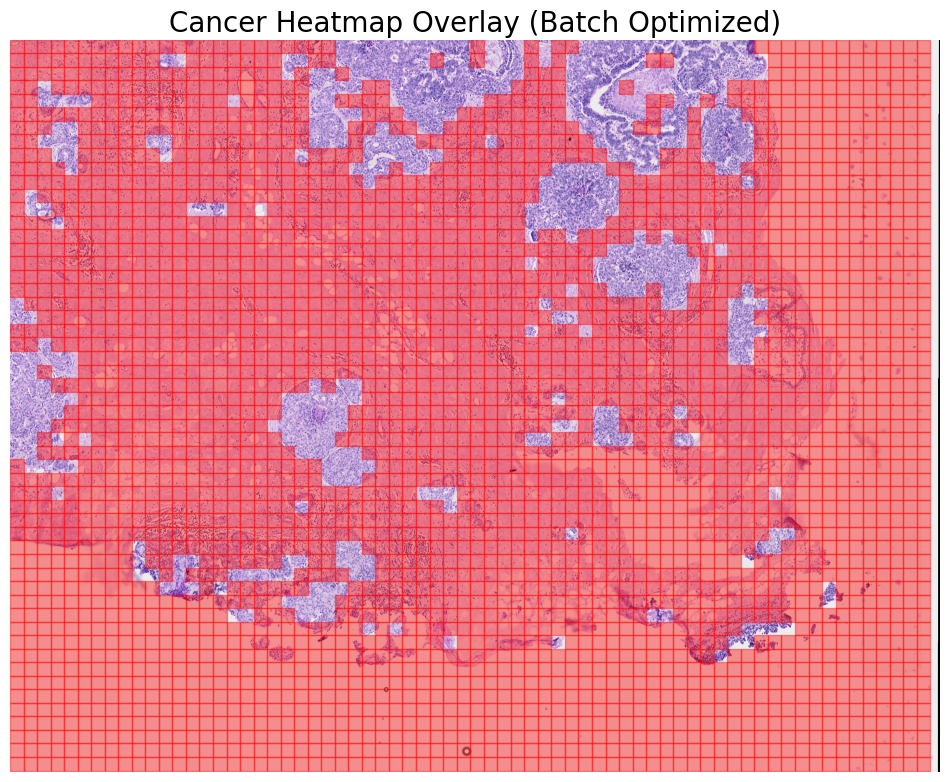

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tensorflow.keras.preprocessing import image
from PIL import Image

# Step 1: Set stride and get image size
stride = 224
img_width, img_height = fourth_quadrant.size

n_cols = img_width // stride
n_rows = img_height // stride

# Step 2: Pre-extract all tiles
tiles = []

for i in range(n_rows):
    for j in range(n_cols):
        left = j * stride
        upper = i * stride
        right = left + stride
        lower = upper + stride
        
        tile = fourth_quadrant.crop((left, upper, right, lower))
        tile_array = image.img_to_array(tile) / 255.0  # normalize
        tiles.append(tile_array)

# Step 3: Stack all tiles into a single batch
tiles_batch = np.stack(tiles, axis=0)

# Step 4: Predict in one go!
predictions = model.predict(tiles_batch, verbose=1, batch_size=32)  # You can adjust batch_size if you want

# Step 5: Reshape predictions back into cancer mask
pred_labels = (predictions.flatten() >= 0.5).astype(int)  # thresholding
cancer_mask = pred_labels.reshape((n_rows, n_cols))

# Step 6: Plot original image
fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(fourth_quadrant)

# Step 7: Overlay cancer predictions
for i in range(n_rows):
    for j in range(n_cols):
        if cancer_mask[i, j] == 1:
            rect = patches.Rectangle(
                (j * stride, i * stride),
                stride, stride,
                linewidth=1,
                edgecolor='red',
                facecolor='red',
                alpha=0.4
            )
            ax.add_patch(rect)

plt.title("Cancer Heatmap Overlay (Batch Optimized)", fontsize=20)
plt.axis('off')
plt.show()
